In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from transformers import GPT2Model, GPT2Config
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
# run to check cuda availability
get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"
get_device()

'cuda:0'

In [3]:
class TransformerModel(nn.Module):
    '''
    This class is a small version of GPT-2 model for in-context learning. 
    It returns the predictions: (batch_size, n_positions)
    '''
    def __init__(self, n_dims, n_positions, n_embd=128, n_layer=6, n_head=4):
        super(TransformerModel, self).__init__()
        configuration = GPT2Config(
            n_positions=2 * n_positions,
            n_embd=n_embd,
            n_layer=n_layer,
            n_head=n_head,
            resid_pdrop=0.0,
            embd_pdrop=0.0,
            attn_pdrop=0.0,
            use_cache=False,
        )
        self.n_positions = n_positions
        self.n_dims = n_dims
        self._read_in = nn.Linear(n_dims, n_embd)
        self._backbone = GPT2Model(configuration)
        self._read_out = nn.Linear(n_embd, 1)

    @staticmethod
    def _combine(xs_b, ys_b):
        """Interleaves the x's and the y's into a single sequence."""
        bsize, points, dim = xs_b.shape
        ys_b_wide = torch.cat(
            (
                ys_b.view(bsize, points, 1),
                torch.zeros(bsize, points, dim - 1, device=ys_b.device),
            ),
            axis=2,
        )
        zs = torch.stack((xs_b, ys_b_wide), dim=2)
        zs = zs.view(bsize, 2 * points, dim)
        return zs

    def forward(self, xs, ys):
        zs = self._combine(xs, ys)
        embeds = self._read_in(zs)
        output = self._backbone(inputs_embeds=embeds).last_hidden_state
        prediction = self._read_out(output)
        return prediction[:, ::2, 0]


In [5]:
from torch.distributions import MultivariateNormal

def sample_xs(b_size, n_points, n_dims, input_cov=None):
    '''
    This function generates random inputs.
        input:
        - input_cov: (n_dim, n_dim) tensor.
        return:
        - xs_b: (b_size, n_points, n_dims) tensor.
    '''
    if input_cov is None:
        xs_b = torch.randn(b_size, n_points, n_dims)
    else:
        sampler = MultivariateNormal(torch.zeros(n_dims), input_cov)
        xs_b = sampler.sample(torch.Size([b_size, n_points]))
    return xs_b


class LinearRegression:
    '''
    This class is to generate linear regression tasks.
        - task_cov: (n_dim, n_dim) tensor.
    '''
    def __init__(self, n_dims, batch_size, task_cov=None):
        super(LinearRegression, self).__init__()
        self.n_dims = n_dims
        self.b_size = batch_size
        self.task_cov = task_cov
        if self.task_cov is None:
            self.w_b = torch.randn(self.b_size, self.n_dims, 1)
        else:
            sampler = MultivariateNormal(torch.zeros(self.n_dims), self.task_cov)
            self.w_b = sampler.sample(torch.Size([self.b_size])).reshape((self.b_size, self.n_dims, 1))

    def evaluate(self, xs_b):
        w_b = self.w_b.to(xs_b.device)
        ys_b = (xs_b @ w_b)[:, :, 0]
        return ys_b

    def get_test_loss(self, ys_pred, ys):
        return (ys - ys_pred).square()

    def get_training_loss(self, ys_pred, ys):
        return (ys - ys_pred).square().mean()

# Implemented class

class DiscreteLinearRegression:
    def __init__(self, n_dims, batch_size):
        super(DiscreteLinearRegression, self).__init__()
        self.n_dims = n_dims
        self.b_size = batch_size
        
        # Enumerating discrete set of weights
        w_b_idx_list = [[0,1], [0,2], [0,3], [0,4], [1,2], [1,3], [1,4], [2,3], [2,4], [3,4]]
        self.w_b_list = []
        for idx_pair in w_b_idx_list:
            a = np.zeros(5)
            a[idx_pair] = 1
            self.w_b_list.append(a)
        self.num_w_b = len(self.w_b_list)
        self.w_b_list = torch.Tensor(self.w_b_list)
                    
        # Sampling from discrete set of weights
        idxs = torch.multinomial(torch.ones(self.num_w_b), self.b_size, replacement=True)
        self.w_b = (self.w_b_list[idxs]).reshape((self.b_size, self.n_dims, 1))

    def evaluate(self, xs_b, noise_std=0):
        w_b = self.w_b.to(xs_b.device)
        noises_b = (torch.randn(xs_b.shape[:2])*noise_std).to(xs_b.device)
        ys_b = (xs_b @ w_b)[:, :, 0] + noises_b
        return ys_b

    def get_test_loss(self, ys_pred, ys):
        return (ys - ys_pred).square()

    def get_training_loss(self, ys_pred, ys):
        return (ys - ys_pred).square().mean()
    

In [7]:
'''
training hyperparameters (Note that you may select your own hyperparameter settings):
    - LR: learning rate
    - OUT_DIR: output directory for saving model checkpoints
    - BATCH_SIZE: training and test batch size
    - N_STEPS: number of training steps
    - N_TEST_STEPS: number of test steps
    - N_DIMS: number of dimensions of linear regression tasks
    - N_POINTS: number of in-context samples (e.g., k)
    - FREQ: frequency of evaluation
'''
LR = 1e-4
OUT_DIR = "models/"
BATCH_SIZE = 64
N_STEPS = 100001
N_TEST_STEPS = 100
N_DIMS = 5
N_POINTS = 11
FREQ = 1000
EVAL_SAMPLES = 6400


def get_task(task_name='linear_regression', task_cov=None):
    '''
    This function is to return the task class.
    '''
    if task_name == 'linear_regression' or task_name == 'linear_regression_non_iso':
        task = LinearRegression(N_DIMS, BATCH_SIZE, task_cov)
    elif task_name == 'discrete_linear_regression' or task_name == 'discrete_linear_regression_noise':
        task = DiscreteLinearRegression(N_DIMS, BATCH_SIZE)
    else:
        print("Unknown task")
        raise NotImplementedError
    return task


def train(model, task_name='linear_regression', input_cov=None, task_cov=None, noise_std=0):
    '''
    This function is to train the model.
        - model: the model to be trained
        - task_name: the name of the task
        - input_cov: (n_dim, n_dim) tensor. the covariance of input x's, None for default (e.g., isotropic)
        - task_cov: (n_dim, n_dim) tensor. the covariance of linear regression tasks w's, None for default (e.g., isotropic)
    '''
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), LR)

    # load model state_dict and optimizer state_dict from the last checkpoint
    test_loss = []
    starting_step = -1
    out_dir = OUT_DIR + task_name
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    state_path = os.path.join(out_dir, "state.pt")
    if os.path.exists(state_path):
        state = torch.load(state_path)
        model.load_state_dict(state["model_state_dict"])
        optimizer.load_state_dict(state["optimizer_state_dict"])
        starting_step = state["train_step"]
        test_loss = state["test_loss"]


    for i in tqdm(range(starting_step+1, N_STEPS)):
        # determine the task class
        task = get_task(task_name, task_cov)
        
        ''' 
        sample x's and evaluate y's
            - xs: (b_size, n_points, n_dims)
            - ys: (b_size, n_points)
            - Note that you may need to move the tensors to the same device as the model.
        '''
        xs = sample_xs(BATCH_SIZE, N_POINTS, N_DIMS, input_cov).cuda()
        ys = task.evaluate(xs, noise_std=noise_std).cuda()

        # model training and update
        optimizer.zero_grad()
        output = model(xs, ys)
        loss = task.get_training_loss(output, ys)
        loss.backward()
        optimizer.step()

        # checkpoint and evaluation
        if not i % FREQ:
            test_loss.append(eval(model, task_name, input_cov, task_cov)[0])
            training_state = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_step": i,
                "test_loss": test_loss,
            }
            torch.save(training_state, state_path)
            
        ''' 
        (optional) Save checkpoints of model state_dict to avoid losing training progress. 
        e.g., At 10000th training step, save the model state_dict at 'state_10000.pt'.
        '''
        

def eval(model, task_name='linear_regression', input_cov=None, task_cov=None):
    '''
        input:
        - model: the model to be evaluated
        - task: the task to be evaluated
        - input_cov: the covariance of input to be evaluated
        - task_cov: the covariance of tasks w's to be evaluated
        return:
        - test_loss (float): the test loss
        - loss (n_points,): the loss for each position
    '''
    model.eval()
    with torch.no_grad():
        test_losses = torch.zeros(N_POINTS).cuda()
        for j in range(N_TEST_STEPS):
            test_loss = 0
            task = get_task(task_name, task_cov)

            xs = sample_xs(BATCH_SIZE, N_POINTS, N_DIMS, input_cov).cuda()
            ys = task.evaluate(xs).cuda()

            output = model(xs, ys)
            batch_test_losses = task.get_test_loss(output, ys)

            test_losses += batch_test_losses.mean(dim=0)/N_TEST_STEPS
        
    return test_losses.mean(), test_losses

def eval_OLS(task_name='linear_regression', input_cov=None, task_cov=None):
    '''
    This function is to perform ordinary least squares (OLS) regression.
        input:
        - task: the task to be evaluated
        - input_cov: the covariance of input to be evaluated
        - task_cov: the covariance of tasks w's to be evaluated
        return:
        - test_loss (float): the test loss
        - loss (n_points,): the loss for each position
    '''
    losses = np.zeros((N_TEST_STEPS, N_POINTS))
    for j in range(N_TEST_STEPS):
        task = get_task(task_name, task_cov)
        xs = sample_xs(BATCH_SIZE, N_POINTS, N_DIMS, input_cov)
        ys = task.evaluate(xs)
        preds = []
        for i in range(N_POINTS):
            if i == 0:
                preds.append(torch.zeros_like(ys[:, 0]))
                continue
            train_xs, train_ys = xs[:, :i], ys[:, :i]
            test_x = xs[:, i : i + 1]
            ws, _, _, _ = torch.linalg.lstsq(train_xs, train_ys.unsqueeze(2))
            pred = test_x @ ws
            preds.append(pred[:, 0, 0])
        preds = torch.stack(preds, dim=1)
        losses[j] = task.get_test_loss(preds, ys).mean(dim=0)
    return losses.mean(), losses.mean(axis=0)

# New function to solve the weighted minimum norm least squares problem
def eval_weighted_OLS(task_name='linear_regression', input_cov=None, task_cov=None):
    '''
    This function is to perform ordinary least squares (OLS) regression.
        input:
        - task: the task to be evaluated
        - input_cov: the covariance of input to be evaluated
        - task_cov: the covariance of tasks w's to be evaluated
        return:
        - test_loss (float): the test loss
        - loss (n_points,): the loss for each position
    '''
    eigvals, V = torch.linalg.eigh(task_cov)
    cov_sqrt = V @ torch.diag(torch.sqrt(eigvals)) @V.T
    losses = np.zeros((N_TEST_STEPS, N_POINTS))
    for j in tqdm(range(N_TEST_STEPS)):
        task = get_task(task_name, task_cov)
        xs = sample_xs(BATCH_SIZE, N_POINTS, N_DIMS, input_cov)
        ys = task.evaluate(xs)
        preds = []
        for i in range(N_POINTS):
            if i == 0:
                preds.append(torch.zeros_like(ys[:, 0]))
                continue
            train_xs, train_ys = xs[:, :i], ys[:, :i].reshape(BATCH_SIZE, i, 1)
            test_x = xs[:, i : i + 1]
            ws = cov_sqrt @ torch.linalg.pinv(train_xs @ cov_sqrt) @ train_ys
            pred = test_x @ ws
            preds.append(pred[:, 0, 0])
        preds = torch.stack(preds, dim=1)
        losses[j] = task.get_test_loss(preds, ys).mean(dim=0)
    return losses.mean(), losses.mean(axis=0)

## Isotropic Inputs
- We train and test the model using linear regression in-context samples.
- We plot the results and report our observations. 

In [8]:
# Completed eval()

# loading initial model
model = TransformerModel(N_DIMS, N_POINTS).cuda()

# training the model
train(model)

# eval
loss_tf_avg, loss_tf = eval(model)
loss_ols_avg, loss_ols = eval_OLS()

0it [00:00, ?it/s]


#### Training curve

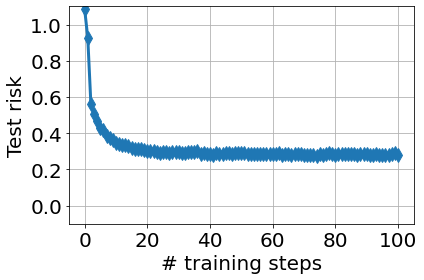

In [12]:
# Plot of test losses across training steps for isotropic linear regression

test_losses_training_tensors = torch.load(OUT_DIR + "linear_regression/state.pt")
test_losses_training = [i.cpu().detach()/N_DIMS for i in test_losses_training_tensors["test_loss"]]
plt.plot(test_losses_training, linewidth=3, marker='d', markersize=10)
plt.xlabel('# training steps', fontsize=20)
plt.ylabel('Test risk', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([-0.1,1.1])
plt.grid()
plt.tight_layout()
plt.savefig('figs/plot_no_cov_training.pdf')
plt.show()

#### OLS vs Transformer

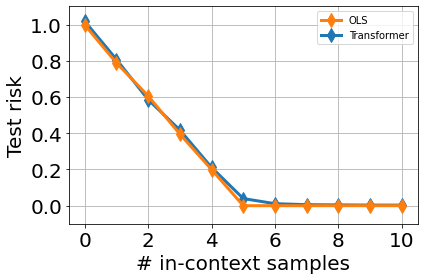

In [9]:
# Plotting OLS vs transformer

data = loss_tf.cpu().detach().numpy()/N_DIMS
ols_data = loss_ols/N_DIMS

fig, ax = plt.subplots()
transformer_plot = ax.plot(data, linewidth=3, marker='d', markersize=10, label = "Transformer")
ols_plot = ax.plot(ols_data, linewidth=3, marker='d', markersize=10, label = "OLS")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
plt.xlabel('# in-context samples', fontsize=20)
plt.ylabel('Test risk', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([-0.1,1.1])
plt.grid()
plt.tight_layout()
plt.savefig('figs/plot_no_cov.png')
plt.show()

## Non-Isotropic Test Inputs and Test Tasks
- We use the model obtained from the isotropic input case.
- We plot the results and report our observations.

#### Non-isotropic test inputs

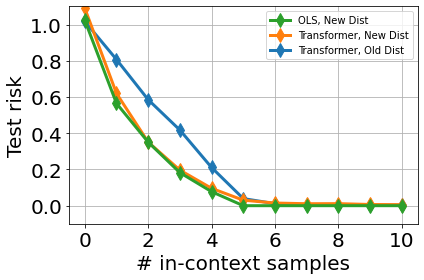

In [11]:
# Define and scale new covariance matrix
cov = torch.diag(torch.Tensor([1,1/4,1/9,1/16, 1/25]))
cov = N_DIMS/torch.trace(cov)*cov

# Loss for transformer (isotropic inputs)
data = loss_tf.cpu().detach().numpy()/N_DIMS

# Loss for transformer (non-isotropic inputs)
non_iso_loss_tf_avg, non_iso_loss_tf = eval(model, input_cov = cov)
non_iso_data = non_iso_loss_tf.cpu().detach().numpy()/N_DIMS

# OLS with non-isotropic inputs
_, non_iso_ols = eval_OLS(input_cov = cov)
non_iso_ols_data = non_iso_ols/N_DIMS

# Plotting
fig, ax = plt.subplots()
transformer_plot = ax.plot(data, linewidth=3, marker='d', markersize=10, label = "Transformer, Old Dist")
non_iso_transformer_plot = ax.plot(non_iso_data, linewidth=3, marker='d', markersize=10, label = "Transformer, New Dist")
ols_plot = ax.plot(non_iso_ols_data, linewidth=3, marker='d', markersize=10, label = "OLS, New Dist")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
plt.xlabel('# in-context samples', fontsize=20)
plt.ylabel('Test risk', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([-0.1,1.1])
plt.grid()
plt.tight_layout()
plt.savefig('figs/plot_non_iso.png')
plt.show()

#### Non-isotropic test tasks

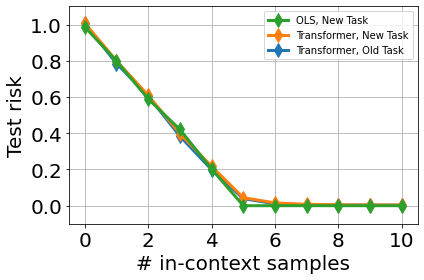

In [21]:
# Define and scale new covariance matrix
cov = torch.diag(torch.Tensor([1,1/4,1/9,1/16, 1/25]))
cov = N_DIMS/torch.trace(cov)*cov

# Loss for transformer (isotropic tasks)
data = loss_tf.cpu().detach().numpy()/N_DIMS

# Loss for transformer (non-isotropic inputs)
non_iso_loss_tf_avg, non_iso_loss_tf = eval(model, task_cov = cov)
non_iso_data = non_iso_loss_tf.cpu().detach().numpy()/N_DIMS

# OLS with non-isotropic tasks
_, non_iso_ols = eval_OLS(task_cov = cov)
non_iso_ols_data = non_iso_ols/N_DIMS

fig, ax = plt.subplots()
transformer_plot = ax.plot(data, linewidth=3, marker='d', markersize=10, label = "Transformer, Old Task")
non_iso_transformer_plot = ax.plot(non_iso_data, linewidth=3, marker='d', markersize=10, label = "Transformer, New Task")
ols_plot = ax.plot(non_iso_ols_data, linewidth=3, marker='d', markersize=10, label = "OLS, New Task")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
plt.xlabel('# in-context samples', fontsize=20)
plt.ylabel('Test risk', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([-0.1,1.1])
plt.grid()
plt.tight_layout()
plt.savefig('figs/plot_non_iso_task_test.png')
plt.show()

## Non-Isotropic Training and Test Tasks
- We train the GPT model using tasks generated from new distribution. 
- We implement a weighted variation of OLS solver.
- We plot the results and report our observations.

In [14]:
# Define and scale new covariance matrix
cov = torch.diag(torch.Tensor([1,1/4,1/9,1/16, 1/25]))
cov = N_DIMS/torch.trace(cov)*cov

# loading initial model
non_iso_task_model = TransformerModel(N_DIMS, N_POINTS).cuda()
# training the model
train(non_iso_task_model, task_name = "linear_regression_non_iso", task_cov = cov)

0it [00:00, ?it/s]


#### Plot for non-isotropic training and testing

100%|██████████| 100/100 [00:00<00:00, 132.75it/s]


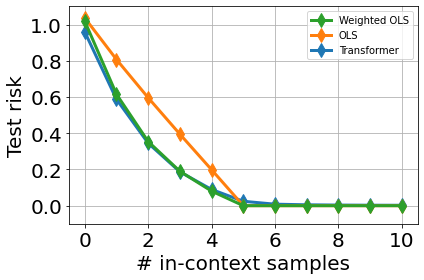

In [36]:
# Define and scale new covariance matrix
cov = torch.diag(torch.Tensor([1,1/4,1/9,1/16, 1/25]))
cov = N_DIMS/torch.trace(cov)*cov

# Loss for transformer 
non_iso_task_loss_tf_avg, non_iso_task_loss_tf = eval(non_iso_task_model, task_cov=cov)
non_iso_task_data = non_iso_task_loss_tf.cpu().detach().numpy()/N_DIMS

# Loss for OLS
_, non_iso_ols_task = eval_OLS(task_name = "linear_regression_non_iso", task_cov=cov)
non_iso_ols_task_data = non_iso_ols_task/N_DIMS

# Loss for weighted OLS
_, non_iso_weighted_ols_task = eval_weighted_OLS(task_name = "linear_regression_non_iso", task_cov=cov)
non_iso_weighted_ols_task_data = non_iso_weighted_ols_task/N_DIMS

fig, ax = plt.subplots()
non_iso_transformer_plot = ax.plot(non_iso_task_data, linewidth=3, marker='d', markersize=10, label = "Transformer")
ols_plot = ax.plot(non_iso_ols_task_data, linewidth=3, marker='d', markersize=10, label = "OLS")
weighted_ols_plot = ax.plot(non_iso_weighted_ols_task_data, linewidth=3, marker='d', markersize=10, label = "Weighted OLS")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
plt.xlabel('# in-context samples', fontsize=20)
plt.ylabel('Test risk', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([-0.1,1.1])
plt.grid()
plt.tight_layout()
plt.savefig('figs/plot_non_iso_task.png')
plt.show()

## Discrete, Finitely Supported Training/Test Tasks + Training Noise
- We repeat the training above for discrete and finitely many training tasks and plot the evaluation results as well as OLS results on the discrete test tasks.
- We retrain the model by adding small noise to the training data and evaluate using noiseless data. 
- We plot the results and report our observations.

In [1]:
# loading initial model
discrete_lin_reg_model = TransformerModel(N_DIMS, N_POINTS).cuda()
# training the discrete linear regression model
train(discrete_lin_reg_model, task_name = 'discrete_linear_regression')

NameError: name 'TransformerModel' is not defined

#### Training curve, discrete vs continuous

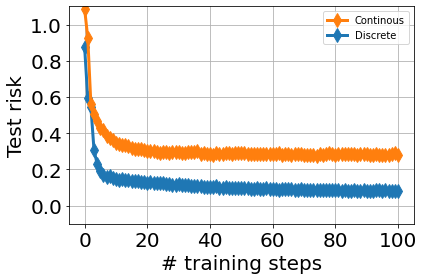

In [22]:
test_losses_training_tensors = torch.load(OUT_DIR + "discrete_linear_regression/state.pt")
test_losses_training = [i.cpu().detach()/2 for i in test_losses_training_tensors["test_loss"]]

lin_reg_test_losses_training_tensors = torch.load(OUT_DIR + "linear_regression/state.pt")
lin_reg_test_losses_training = [i.cpu().detach()/N_DIMS for i in lin_reg_test_losses_training_tensors["test_loss"]]

fig, ax = plt.subplots()

discrete_lin_reg = ax.plot(test_losses_training, linewidth=3, marker='d', markersize=10, label = "Discrete")
lin_reg = ax.plot(lin_reg_test_losses_training, linewidth=3, marker='d', markersize=10, label = "Continous")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
plt.xlabel('# training steps', fontsize=20)
plt.ylabel('Test risk', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([-0.1,1.1])
plt.grid()
plt.tight_layout()
plt.savefig('figs/plot_discrete_lin_training.png')
plt.show()

#### Loss vs in-context examples, discrete vs isotropic cts vs non-isotropic cts

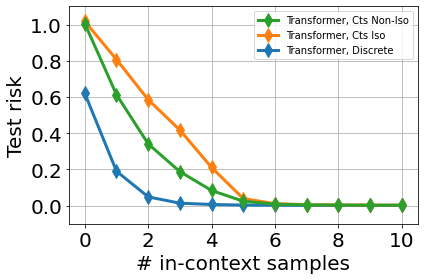

In [24]:
cov = torch.diag(torch.Tensor([1,1/4,1/9,1/16, 1/25]))
cov = N_DIMS/torch.trace(cov)*cov

discrete_loss_tf_avg, discrete_loss_tf = eval(discrete_lin_reg_model, task_name='discrete_linear_regression')
discrete_data = discrete_loss_tf.cpu().detach().numpy()/2

data = loss_tf.cpu().detach().numpy()/N_DIMS
non_iso_task_loss_tf_avg, non_iso_task_loss_tf = eval(non_iso_task_model, task_cov=cov)
non_iso_task_data = non_iso_task_loss_tf.cpu().detach().numpy()/N_DIMS

_, discrete_ols = eval_OLS(task_name = "discrete_linear_regression_noise")
discrete_ols_data = discrete_ols/2

fig, ax = plt.subplots()
discrete_transformer_plot = ax.plot(discrete_data, linewidth=3, marker='d', markersize=10, label = "Transformer, Discrete")
transformer_plot = ax.plot(data, linewidth=3, marker='d', markersize=10, label = "Transformer, Cts Iso")
non_iso_transformer_plot = ax.plot(non_iso_task_data, linewidth=3, marker='d', markersize=10, label = "Transformer, Cts Non-Iso")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
plt.xlabel('# in-context samples', fontsize=20)
plt.ylabel('Test risk', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([-0.1,1.1])
plt.grid()
plt.tight_layout()
plt.savefig('figs/plot_discrete_lin_reg.png')
plt.show()

#### Training for noisy discrete linear regression

In [25]:
# loading initial model
discrete_lin_reg_noise_model = TransformerModel(N_DIMS, N_POINTS).cuda()
# training the model
train(discrete_lin_reg_noise_model, task_name = 'discrete_linear_regression_noise', noise_std = np.sqrt(0.001))

0it [00:00, ?it/s]


#### Training curve for noisy discrete linear regression

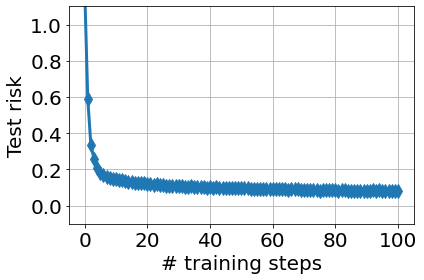

In [31]:
noisy_test_losses_training_tensors = torch.load(OUT_DIR + "discrete_linear_regression_noise/state.pt")
noisy_test_losses_training = [i.cpu().detach()/2 for i in noisy_test_losses_training_tensors["test_loss"]]

# clean_test_losses_training_tensors = torch.load(OUT_DIR + "discrete_linear_regression/state.pt")
# clean_test_losses_training = [i.cpu().detach()/2 for i in clean_test_losses_training_tensors["test_loss"]]

fig, ax = plt.subplots()

discrete_noisy = ax.plot(noisy_test_losses_training, linewidth=3, marker='d', markersize=10)
# discrete_standard = ax.plot(clean_test_losses_training, linewidth=3, marker='d', markersize=10, label = "Standard")

# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[::-1], labels[::-1])
plt.xlabel('# training steps', fontsize=20)
plt.ylabel('Test risk', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([-0.1,1.1])
plt.grid()
plt.tight_layout()
plt.savefig('figs/plot_discrete_lin_noise_training.png')
plt.show()

#### Comparing noisy and standard discrete linear regression (loss vs in-context examples)

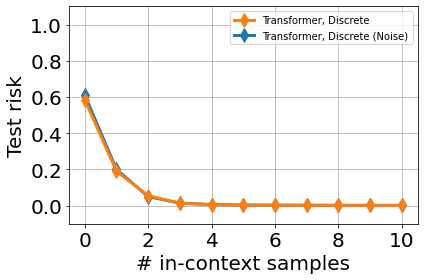

In [53]:
cov = torch.diag(torch.Tensor([1,1/4,1/9,1/16, 1/25]))
cov = N_DIMS/torch.trace(cov)*cov

discrete_noise_loss_tf_avg, discrete_noise_loss_tf = eval(discrete_lin_reg_noise_model, task_name='discrete_linear_regression_noise')
discrete_noise_data = discrete_noise_loss_tf.cpu().detach().numpy()/2
discrete_loss_tf_avg, discrete_loss_tf = eval(discrete_lin_reg_model, task_name='discrete_linear_regression')
discrete_data = discrete_loss_tf.cpu().detach().numpy()/2

fig, ax = plt.subplots()
discrete_noise_transformer_plot = ax.plot(discrete_noise_data, linewidth=3, marker='d', markersize=10, label = "Transformer, Discrete (Noise)")
discrete_transformer_plot = ax.plot(discrete_data, linewidth=3, marker='d', markersize=10, label = "Transformer, Discrete")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
plt.xlabel('# in-context samples', fontsize=20)
plt.ylabel('Test risk', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([-0.1,1.1])
plt.grid()
plt.tight_layout()
plt.savefig('figs/plot_discrete_lin_reg_noise.png')
plt.show()